In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn
import torch
import os
import warnings

warnings.filterwarnings('ignore')

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [3]:
import torchvision
from torchvision import transforms

In [4]:
pretrained_weights = torchvision.models.ViT_B_16_Weights.DEFAULT



train_dir = '/kaggle/input/dataset/dogs-vs-cats/train'
test_dir =  '/kaggle/input/dataset/dogs-vs-cats/test'

# vit model instance for pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_weights).to(device)

# Freezes all the parameters of the pretrained ViT model to prevent them from being updated during training.

for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

classes = ['cat','dog']

torch.manual_seed(42)
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(classes)).to(device)

In [5]:
from torchinfo import summary

summary(model=pretrained_vit, 
        input_size=(8, 3, 224, 224), # (batch_size, color_channels, height, width)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [8, 3, 224, 224]     [8, 2]               768                  Partial
├─Conv2d (conv_proj)                                         [8, 3, 224, 224]     [8, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [8, 197, 768]        [8, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [8, 197, 768]        [8, 197, 768]        --                   --
│    └─Sequential (layers)                                   [8, 197, 768]        [8, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [8, 197, 768]        [8, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [8, 197, 768]        [8, 1

In [6]:
pretrained_vit_transforms = pretrained_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [7]:
from torchvision import datasets
from torch.utils.data import DataLoader
import os

NUM_WORKERS = os.cpu_count()   # setting no of processors for loading data

def create_dataloader(
    train_dir : str,
    test_dir : str,
    transform : transforms.Compose,
    batch_size :int,
    num_workers : int = NUM_WORKERS
    ):

# use image folder to create dataset

    train_data = datasets.ImageFolder(train_dir,transform=transform)
    test_data = datasets.ImageFolder(test_dir,transform=transform)

    # To get Classes
    class_names = train_data.classes

    # Load the images
    train_data_loader = DataLoader(
        train_data,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
    )

    test_data_loader = DataLoader(
        test_data,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
    )

    return train_data_loader,test_data_loader,class_names

In [8]:
train_data_loader_pretrained, test_data_loader_pretrained, class_names = create_dataloader(
    train_dir=train_dir,
    test_dir=test_dir,
    batch_size= 8,
    transform=pretrained_vit_transforms
)

# Display class names
print("Class names:", class_names)

Class names: ['cats', 'dogs']


In [9]:
import sys
sys.path.append('/kaggle/input/gmodular/going_modular')

In [10]:
import engine
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=3e-3)

# Setup the loss function for multi-class classification
loss_fn = torch.nn.CrossEntropyLoss()

# Set the seeds
torch.manual_seed(42)

# Train the model and save the training results to a dictionary
results = engine.train(model=pretrained_vit,
                       train_dataloader=train_data_loader_pretrained,
                       test_dataloader=test_data_loader_pretrained,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.0426 | train_acc: 0.9900 | test_loss: 0.0351 | test_acc: 0.9930
Epoch: 2 | train_loss: 0.0080 | train_acc: 0.9980 | test_loss: 0.0424 | test_acc: 0.9890
Epoch: 3 | train_loss: 0.0035 | train_acc: 0.9995 | test_loss: 0.0319 | test_acc: 0.9920
Epoch: 4 | train_loss: 0.0011 | train_acc: 1.0000 | test_loss: 0.0326 | test_acc: 0.9920
Epoch: 5 | train_loss: 0.0006 | train_acc: 1.0000 | test_loss: 0.0330 | test_acc: 0.9910


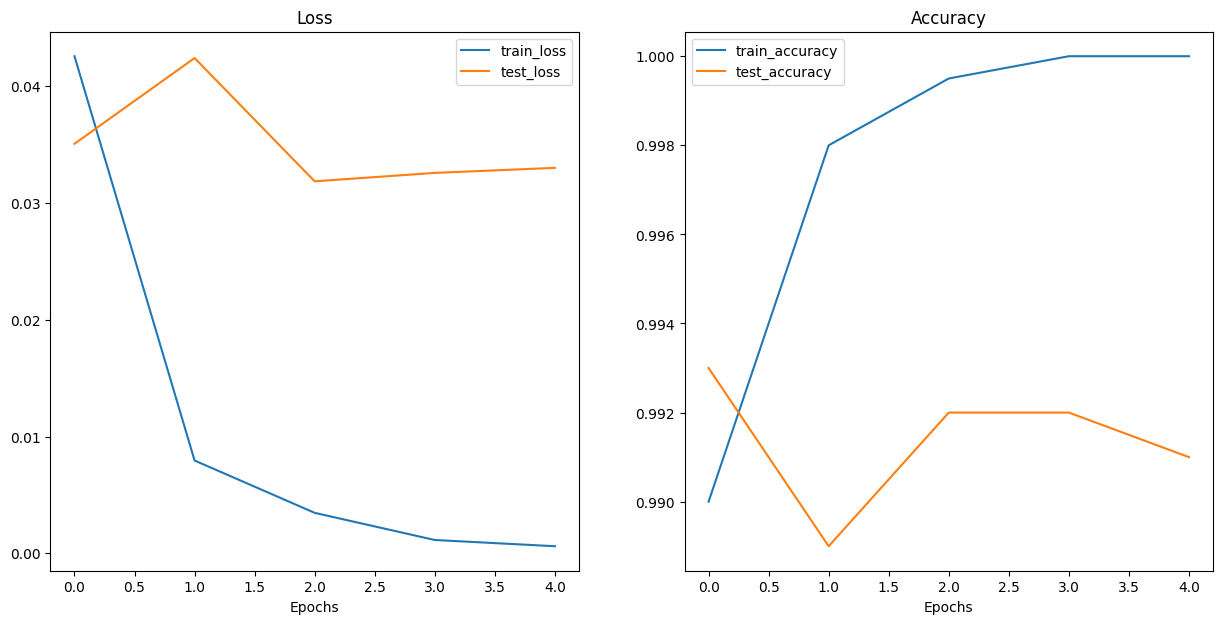

In [11]:
def plot_loss_curves(results):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()


plot_loss_curves(results)

In [12]:
import os
import json

# Define the path to the kaggle.json file you just downloaded
kaggle_json_path = '/kaggle/input/kaggleapi/kaggle.json'

# Make sure the .kaggle directory exists
os.makedirs('/root/.kaggle', exist_ok=True)

# Copy the kaggle.json file to the .kaggle directory
with open(kaggle_json_path, 'r') as f:
    kaggle_data = json.load(f)

with open('/root/.kaggle/kaggle.json', 'w') as f:
    json.dump(kaggle_data, f)

# Set permissions to read and write for the user
os.chmod('/root/.kaggle/kaggle.json', 0o600)


Selected image path: /kaggle/input/dataset/dogs-vs-cats/test/dogs/dog.10141.jpg


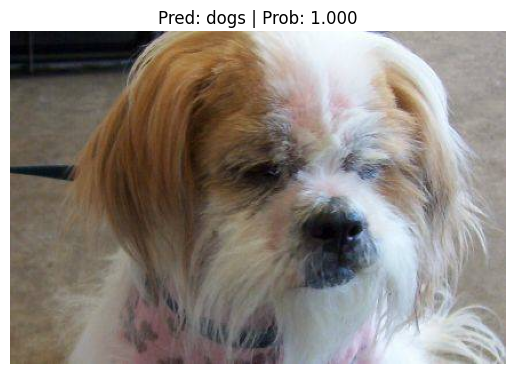

In [18]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from typing import List, Tuple
import random
from pathlib import Path

def pred_and_plot_image(
    model: torch.nn.Module,
    class_names: List[str],
    image_path: str,
    image_size: Tuple[int, int] = (224, 224),
    transform: transforms = None,
    device: torch.device = torch.device("cuda" if torch.cuda.is_available() else "cpu"),
):
    img = Image.open(image_path)

    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

    model.to(device)
    model.eval()
    with torch.inference_mode():
        transformed_image = image_transform(img).unsqueeze(dim=0)
        target_image_pred = model(transformed_image.to(device))

    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_label.item()]} | Prob: {target_image_pred_probs.max().item():.3f}")
    plt.axis(False)

test_folder = Path("/kaggle/input/dataset/dogs-vs-cats/test")
all_files = list(test_folder.glob('*/*'))
random_image_path = random.choice(all_files)
print(f"Selected image path: {random_image_path}")

pred_and_plot_image(model=pretrained_vit, image_path=str(random_image_path), class_names=class_names)
